# Preliminary Results

In [1]:
# Load the necessary packages.
library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Importing Data

In [2]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"

filepath <- "../data/forestfires.csv"

# download the file if its not present
if (!file.exists(filepath)) {
    download.file(url, filepath)
}

# select the columns we need, and filter out NA values
forest_fires_data <-read_delim(filepath, skip=0, delim=",") %>%
    select(wind, area) %>%
    mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
    filter(!is.na(wind) | !is.na(area))
    
head(forest_fires_data)

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


wind,area
<dbl>,<dbl>
6.7,0
0.9,0
1.3,0
4.0,0
1.8,0
5.4,0


## Wind Speed Distributions

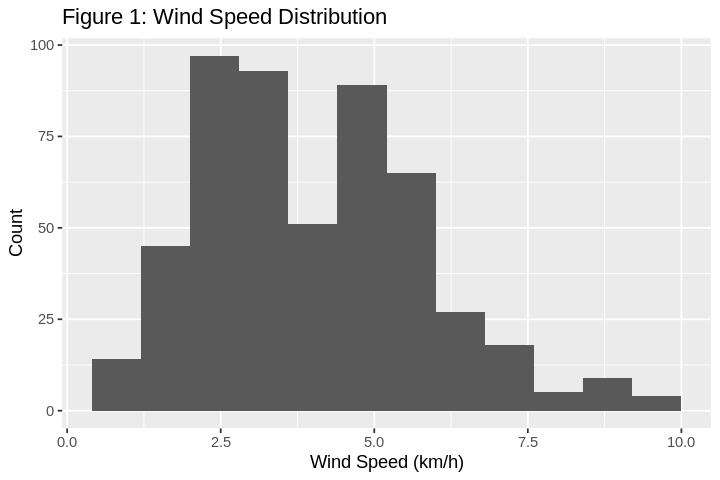

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)

## Plotting out the distribution of the wind speeds from the data
wind_speed_plot <- forest_fires_data %>%
    ggplot(aes(x = wind))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed (km/h)", y="Count")+
    ggtitle("Figure 1: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 11)) 

wind_speed_plot

In Figure 1 we can see that the distribution follows a bimodal distribution. This allows us to use the two peaks as reference as to whether or not any particular windspeed should be classified as either "high" speed or "low" speed.

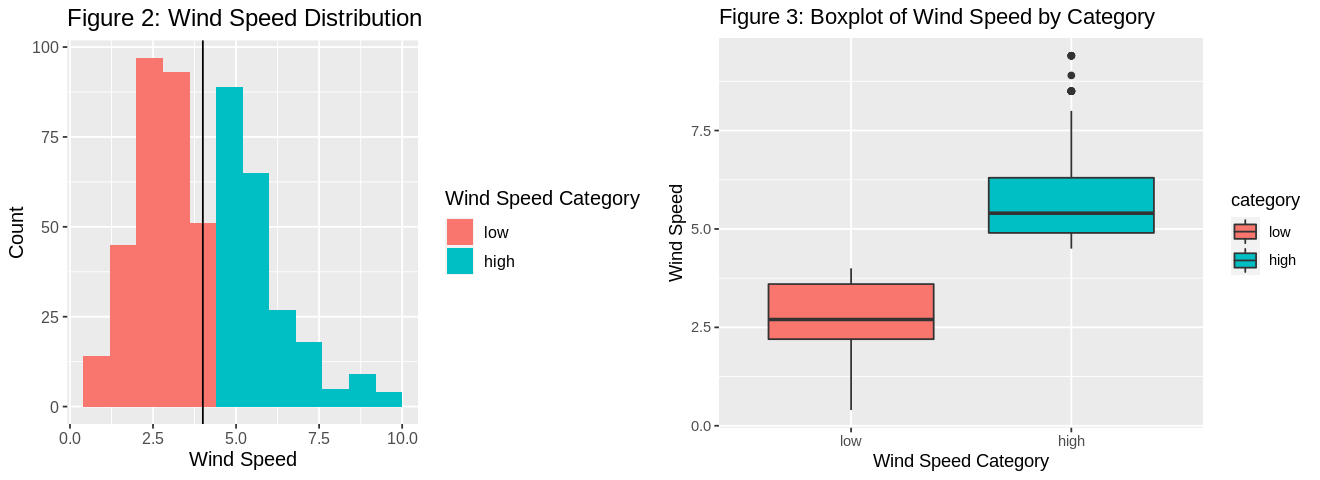

In [4]:
xs <- quantile(forest_fires_data$wind,c(0,1/2,1))

## adding the category column
forest_fires_data <- forest_fires_data %>%
    mutate(category=cut(wind, breaks=xs, labels=c("low","high"),include.lowest = TRUE))

## visualizing the split between "high" and "low" windspeed
wind_plot_categorized <- forest_fires_data %>%
    ggplot(aes(x = wind, fill = category))+
    geom_histogram(binwidth = 0.8) + 
    labs(x = "Wind Speed", y="Count")+
    ggtitle("Figure 2: Wind Speed Distribution") +
    scale_fill_discrete(name = "Wind Speed Category") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))

## creating boxplot for "high" and "low" windspeeds distributions
box_plot <- forest_fires_data %>%
  ggplot(aes(x = category, y = wind, fill = category)) +
  geom_boxplot() +
  labs(x="Wind Speed Category", y="Wind Speed") +
  ggtitle("Figure 3: Boxplot of Wind Speed by Category") 

options(repr.plot.width = 11, repr.plot.height = 4)
plot_grid(wind_plot_categorized, box_plot)

Figure 2 simply visualizes how the high-low split looks like. Figure 3 is reiterating the same information but with a box plot instead. Due to the manner by which we deriaved the high and low catagories, there's no overlap between the two of them.

## Area Burned Distributions

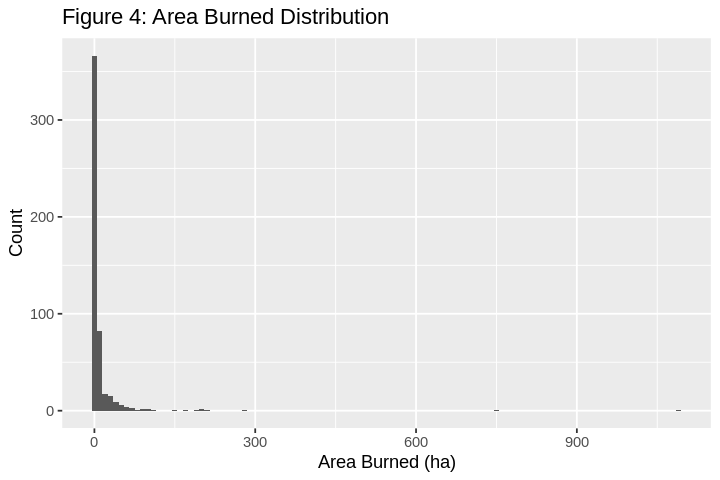

In [5]:
options(repr.plot.width = 6, repr.plot.height = 4)

## Plotting the distribution of area burned from data
area_burned_plot <- forest_fires_data %>%
    ggplot(aes(x = area))+
    geom_histogram(binwidth = 10) + 
    labs(x = "Area Burned (ha)", y = "Count")+
    ggtitle("Figure 4: Area Burned Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 11))
area_burned_plot   

Figure 4 shows a massive right skew in the data. This structure means that it would make sense to scale the data using a logrithmic scale.
> See https://www.programmingr.com/tutorial/log-in-r/.

In [6]:
## Adding log scale column 
forest_fires_data <- forest_fires_data %>%
    mutate(area_log10 = log10(1+ area))

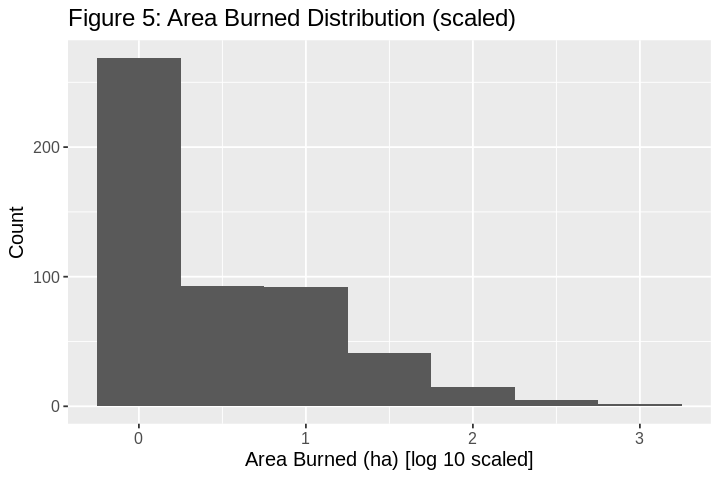

In [12]:
options(repr.plot.width = 6, repr.plot.height = 4)

## Plotting area burned distribution with the newly scaled data
area_burned_scaled_plot <- forest_fires_data %>%
    ggplot(aes(x =area_log10))+
    geom_histogram(binwidth = 0.5) + 
    labs(x="Area Burned (ha) [log 10 scaled]", y="Count")+
    ggtitle("Figure 5: Area Burned Distribution (scaled)") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12))

## Plotting boxplot of area burned with respect to which wind speed catagory the observation belongs to
box_plot_burned <- forest_fires_data %>%
  ggplot(aes(x = category, y = area_log10, fill = category)) +
  geom_boxplot() +
  labs(x="Scaled Area vs Wind Speed Category", y="Scaled Area Burned (ha)")+
  ggtitle("Figure 6: Boxplot of Area Burned by Category")

area_burned_scaled_plot

Figure 5 is the newly scaled distribution for the area burned. We can see that it still follows a similar shape as before, but it's a bit easier to see what's actually going on. 

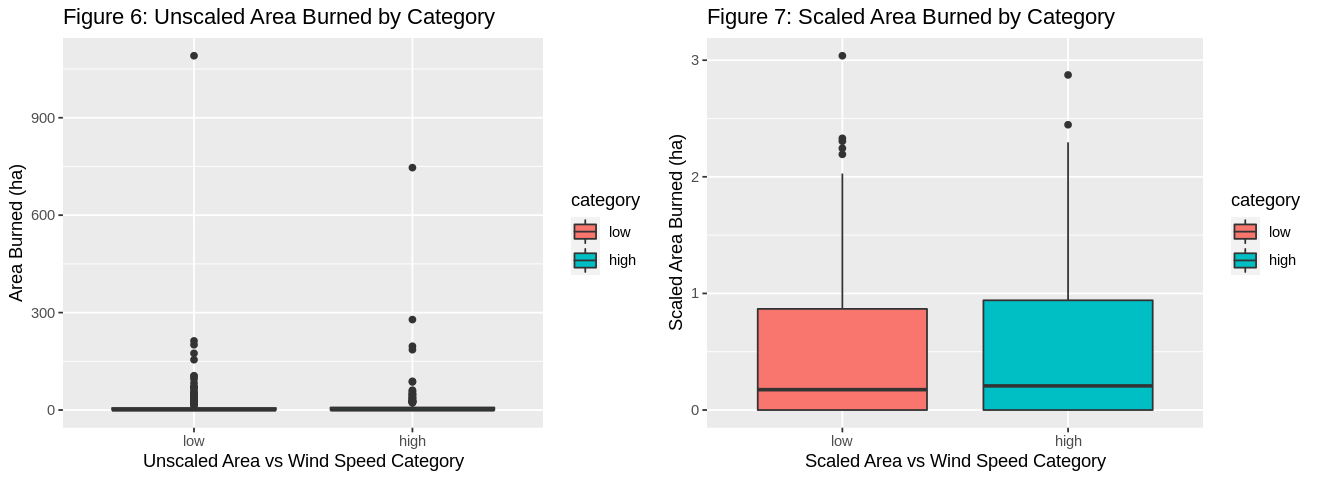

In [18]:
## Plotting boxplot of area burned with respect to which wind speed catagory the observation belongs to
box_plot_burned_unscaled <- forest_fires_data %>%
  ggplot(aes(x = category, y = area, fill = category)) +
  geom_boxplot() +
  labs(x = "Unscaled Area vs Wind Speed Category", y = "Area Burned (ha)")+
  ggtitle("Figure 6: Unscaled Area Burned by Category")

## Plotting boxplot of area burned [scaled] with respect to which wind speed catagory the observation belongs to
box_plot_burned_scaled <- forest_fires_data %>%
  ggplot(aes(x = category, y = area_log10, fill = category)) +
  geom_boxplot() +
  labs(x = "Scaled Area vs Wind Speed Category", y = "Scaled Area Burned (ha)")+
  ggtitle("Figure 7: Scaled Area Burned by Category")


options(repr.plot.width = 11, repr.plot.height = 4)
plot_grid(box_plot_burned_unscaled, box_plot_burned_scaled)

Figure 6 and 7 show the unscaled and scaled area burned distributions under both wind catagories. We can see here that the two catagories actually have very similar distributions, with a slighly higher variance in "high" wind speed catagory compared to the "low" wind speed catagory.

In [19]:
## Creating summary statistic for "low" wind speed catagory
forest_fires_data %>%
group_by(category) %>%
filter(category == "low") %>%
summary()

## Creating summary statistic for "high" wind speed catagory
forest_fires_data %>%
group_by(category) %>%
filter(category == "high") %>%
summary()

      wind            area          category     area_log10    
 Min.   :0.400   Min.   :   0.000   low :300   Min.   :0.0000  
 1st Qu.:2.200   1st Qu.:   0.000   high:  0   1st Qu.:0.0000  
 Median :2.700   Median :   0.495              Median :0.1746  
 Mean   :2.779   Mean   :  12.615              Mean   :0.4699  
 3rd Qu.:3.600   3rd Qu.:   6.365              3rd Qu.:0.8672  
 Max.   :4.000   Max.   :1090.840              Max.   :3.0382  

      wind            area        category     area_log10    
 Min.   :4.500   Min.   :  0.00   low :  0   Min.   :0.0000  
 1st Qu.:4.900   1st Qu.:  0.00   high:217   1st Qu.:0.0000  
 Median :5.400   Median :  0.61              Median :0.2068  
 Mean   :5.729   Mean   : 13.17              Mean   :0.5000  
 3rd Qu.:6.300   3rd Qu.:  7.73              3rd Qu.:0.9410  
 Max.   :9.400   Max.   :746.28              Max.   :2.8735  

Most of these stats for the wind are what you would expect to see given how we split that data to create the catagories. The area of interest here is how the catgory differences are reflected in the area and area_log 10 columns. We can see here that most of the statistic are pretty similar, with even the MAX on the "low" catagory having a significantly higher MAX than the "high" catagory (which is pretty suprising), but that the "high" catagory still has a higher MEAN (though the difference is pretty small).